In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler


import nibabel

In [2]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [3]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [4]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = self.image_dir[idx]
        aseg_path = self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-5,5)
        dx = np.round(random.uniform(-10,10))
        dy = np.round(random.uniform(-10,10))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))/255
        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((46,256,256))
        for i,a in enumerate(available_segments):
            target_label[i,:,:] = (target==a).astype(int)
        target_label = torch.from_numpy(target_label)
        sample = {'x':im,'y':target_label} 
        return sample

In [5]:
# # torch.from_numpy()
# train_file_names = unpickling("/scratch/ark576/train_file_names")
# train_label_names = unpickling("/scratch/ark576/train_label_names")
# rand1 = np.arange(len(train_file_names))
# np.random.shuffle(rand1)
# rand1 = rand1[:1000]

# val_file_names = unpickling("/scratch/ark576/val_file_names")
# val_label_names = unpickling("/scratch/ark576/val_label_names")
# rand2 = np.arange(len(val_file_names))
# np.random.shuffle(rand2)
# rand2 = rand2[:250]

# test_file_names = unpickling("/scratch/ark576/test_file_names")
# test_label_names = unpickling("/scratch/ark576/test_label_names")
# rand3 = np.arange(len(test_file_names))
# np.random.shuffle(rand3)
# rand3 = rand3[:3]




In [6]:
file_names = pd.read_csv("all_complete_path.csv")

In [7]:
file_names.head()

,left_to_right_raw,left_to_right_segmented,top_to_bottom_raw,top_to_bottom_segmented,back_to_front_raw,back_to_front_segmented
0,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
1,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
2,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
3,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
4,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...


In [8]:
train_subjects = unpickling("train_subject_index")
val_subjects = unpickling("val_subject_index")
test_subjects = unpickling("test_subject_index")

In [9]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [10]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:1000]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:500]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [11]:
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2]),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3])
                                               }

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=12,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [16]:
inputs = next(iter(dataloader['train']))

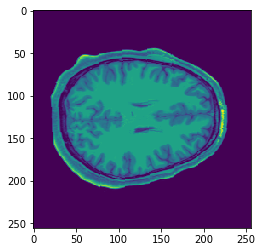

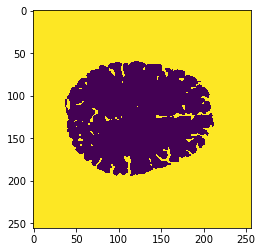

In [17]:
j = 3
plt.imshow(inputs['x'][1,0,:,:].numpy())
plt.show()
plt.imshow(inputs['y'][1,0,:,:].numpy())
plt.show()

In [18]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [19]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [20]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(1,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,46, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [21]:
voxel_count = pd.read_csv('/cbi/hcp/hcp_seg/brain_segmentation/segment_counts.csv')

In [22]:
wts_num = np.mean(np.array(voxel_count.iloc[:,available_segments]),axis = 0)

In [23]:
wts_torch = Variable(torch.from_numpy(wts_num)).cuda()

In [24]:
def dice_loss_2(true,scores,mean, epsilon = 1e-4,p = 1):
    preds = F.softmax(scores)
    N, C, sh1, sh2 = true.size()
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
#     print(wts)
    mean = 1/torch.pow(mean,p)
#     print(wts.size())
#     print(mean)
#     wts = torch.clamp(wts,0,0.1)
    wts[:,:] = mean[None].repeat(N,1)
#     wts[:,-1] = 0
#     wts[wts == 0.1] = 0
    wts = wts/(torch.sum(wts,dim = 1)[:,None])
    #print(wts)
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
    return torch.mean(loss)

In [25]:
def dice_score(true,scores, epsilon = 1e-7):
    N ,C, sh1, sh2 = true.size()
    true = true.view(N,C,-1)
    #print(true.size())
    preds = F.softmax(scores)
    pred_class = (torch.max(preds, dim = 1)[1]).view(N,-1)
    class_score = [0]*46
    for i in range(46):
        class_score[i] = (pred_class == i).data.type(torch.cuda.FloatTensor)
        
#     class_0_pred_seg = (pred_class == 0).data.type(torch.cuda.FloatTensor)
#     class_1_pred_seg = (pred_class == 1).data.type(torch.cuda.FloatTensor)
#     class_2_pred_seg = (pred_class == 2).data.type(torch.cuda.FloatTensor)
    true = true.data.type(torch.cuda.FloatTensor)
    def numerator(truth,pred, idx):
        #print(type(truth))
        #print(truth[:,int(idx),:].size())
        return(torch.sum(truth[:,idx,:] * pred,dim = 1)) + epsilon/2
    def denominator(truth,pred,idx):
        return(torch.sum(truth[:,idx,:]+pred,dim = 1)) + epsilon
    dice_class_score = [0]*46
    for i in range(46):
        dice_class_score[i] = torch.mean(2*(numerator(true,class_score[i],i))/(denominator(true,class_score[i],i)))
#     dice_score_class_0 = torch.mean(2*(numerator(true,class_0_pred_seg,0))/(denominator(true,class_0_pred_seg,0)))
#     dice_score_class_1 = torch.mean(2*(numerator(true,class_1_pred_seg,1))/(denominator(true,class_1_pred_seg,1)))
#     dice_score_class_2 = torch.mean(2*(numerator(true,class_2_pred_seg,2))/(denominator(true,class_2_pred_seg,2)))
    
#    return (dice_score_class_0,dice_score_class_1, dice_score_class_2)
    return dice_class_score
    

In [26]:
import time
def train_model(model, optimizer,dataloader, data_sizes, batch_size, num_epochs = 100, verbose = False):
    since = time.time()
    best_loss = np.inf
    loss_hist = {'train':[],'validate':[]}
    dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(46)]    
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            run_class_scores = [0]*46
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).type(torch.FloatTensor).cuda()
                y = Variable(y).type(torch.FloatTensor).cuda()
                
                output = model(x)
                loss = dice_loss_2(y, output,wts_torch)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * batch_size
                dice_score_batch = dice_score(y,output)

                for j in range(46):
                    run_class_scores[j] = run_class_scores[j] + dice_score_batch[j] * batch_size
            epoch_loss = running_loss/data_sizes[phase]
            loss_hist[phase].append(epoch_loss.item()) 
            for j in range(46):
                score = run_class_scores[j]/data_sizes[phase]
                dice_scores_of_all_class[j][phase].append(score.to(torch.device("cpu")).numpy())
            if verbose or i%1 == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}'.format(i,phase,epoch_loss))
                print('-'*10)
            
        if phase == 'validate' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = model.state_dict() 
        print(i)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}'.format(best_loss))
    
    model.load_state_dict(best_model_wts)
    
    return model, loss_hist, dice_scores_of_all_class

In [30]:
model = Unet().cuda()
model = nn.DataParallel(model)
criterion = dice_loss_2

optimizer = optim.Adam(model.parameters(),lr = 5e-4)

In [31]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,data_sizes,12,
                                                                num_epochs = 60, verbose = True)

Epoch: 0, Phase: train, epoch loss: 1.0080
----------
Epoch: 0, Phase: validate, epoch loss: 1.0080
----------
0
Epoch: 1, Phase: train, epoch loss: 1.0080
----------
Epoch: 1, Phase: validate, epoch loss: 1.0079
----------
1
Epoch: 2, Phase: train, epoch loss: 1.0080
----------
Epoch: 2, Phase: validate, epoch loss: 1.0079
----------
2
Epoch: 3, Phase: train, epoch loss: 1.0079
----------
Epoch: 3, Phase: validate, epoch loss: 1.0080
----------
3
Epoch: 4, Phase: train, epoch loss: 1.0076
----------
Epoch: 4, Phase: validate, epoch loss: 1.0072
----------
4
Epoch: 5, Phase: train, epoch loss: 0.9947
----------
Epoch: 5, Phase: validate, epoch loss: 0.9291
----------
5
Epoch: 6, Phase: train, epoch loss: 0.5958
----------
Epoch: 6, Phase: validate, epoch loss: 0.6489
----------
6
Epoch: 7, Phase: train, epoch loss: 0.4672
----------
Epoch: 7, Phase: validate, epoch loss: 0.5937
----------
7
Epoch: 8, Phase: train, epoch loss: 0.4358
----------
Epoch: 8, Phase: validate, epoch loss: 0.4

In [41]:
torch.save(model.state_dict(), "model1")

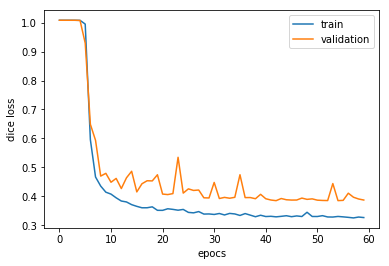

In [42]:
plt.plot(loss_hist["train"],label="train")
plt.plot(loss_hist["validate"],label = "validation")
plt.ylabel("dice loss")
plt.xlabel("epocs")
plt.legend()
plt.show()

In [83]:
pickling(dice_hist,"model1_dice_hist")

In [60]:
data = next(iter(dataloader["validate"]))

In [61]:
model.train(False)
x = data['x']
y = data['y']
x = Variable(x).type(torch.FloatTensor).cuda()
y = Variable(y).type(torch.FloatTensor).cuda()
                
output = model(x)

In [62]:
def visualize(image, class_viz, title):
    p = F.softmax(image)
    p_maxim = torch.max(p, dim=0)[1]
    masked = (p_maxim==class_viz).data.type(torch.cuda.FloatTensor)
    plt.title(title)
    plt.imshow(masked[:,:].cpu().numpy())

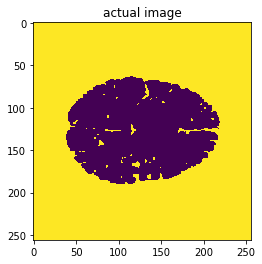

In [63]:
visualize(data['y'][3,:,:,:],0,"actual image") 

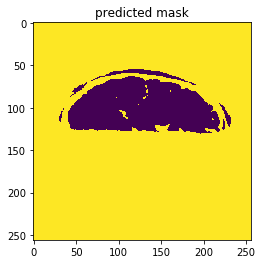

In [64]:
visualize(output[3,:,:,:],0,"predicted mask")

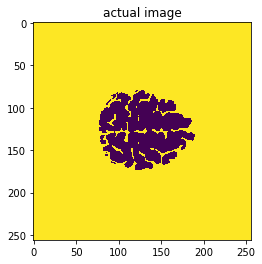

In [58]:
visualize(data['y'][5,:,:,:],0,"actual image") 

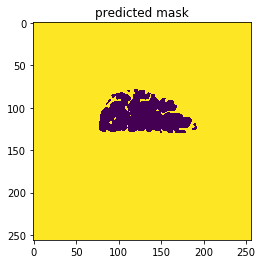

In [59]:
visualize(output[5,:,:,:],0,"predicted mask")

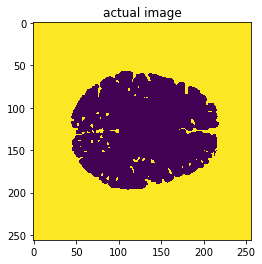

In [81]:
visualize(data['y'][8,:,:,:],0,"actual image") 

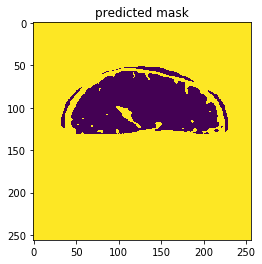

In [82]:
visualize(output[8,:,:,:],0,"predicted mask")

In [67]:
names = []
for i in range(60):
    name = "epoch"+str(i)
    names.append(name)

In [68]:
train_dice_scores = pd.DataFrame(columns=names)
val_dice_scores = pd.DataFrame(columns=names)

In [69]:
for i in range(46):
    class_i_train = dice_hist[i]['train']
    class_i_val = dice_hist[i]['validate']
    
    train_dice_scores.loc[i] = class_i_train
    val_dice_scores.loc[i] = class_i_val

In [70]:
train_dice_scores

,epoch0,epoch1,epoch2,epoch3,epoch4,epoch5,epoch6,epoch7,epoch8,epoch9,...,epoch50,epoch51,epoch52,epoch53,epoch54,epoch55,epoch56,epoch57,epoch58,epoch59
0,8.673726e-07,1.6700875e-12,1.6694096e-12,0.77837664,0.92734456,0.86915904,0.82000905,0.9511289,0.97374505,0.98228234,...,0.9851804,0.9846798,0.9849813,0.9850366,0.9852891,0.98488307,0.98540545,0.98548305,0.9851322,0.9853795
1,0.61700004,0.61600006,0.61600006,0.52132314,0.614,0.58730257,0.5960059,0.614,0.61800003,0.61600006,...,0.61800003,0.61600006,0.61800003,0.61800003,0.61600006,0.61600006,0.62,0.62,0.61800003,0.62
2,0.578,0.57600003,0.57600003,0.578,0.574,0.57214487,0.574,0.574,0.57600003,0.5761807,...,0.578,0.57600003,0.578,0.578,0.57600003,0.57600003,0.58000004,0.58000004,0.578,0.58000004
3,0.00012414789,2.297917e-12,0.010000001,0.69900006,0.91300005,0.9110001,0.9110001,0.9110001,0.91300005,0.91300005,...,0.91300005,0.90900004,0.91300005,0.91300005,0.91300005,0.91300005,0.91300005,0.91300005,0.9110001,0.91300005
4,0.94500005,0.95100003,0.95100003,0.94900006,0.94900006,0.95100003,0.94900006,0.94900006,0.95100003,0.94900006,...,0.95100003,0.95100003,0.95100003,0.95100003,0.95100003,0.95100003,0.95100003,0.95100003,0.95100003,0.95100003
5,0.855,0.864,0.864,0.86200005,0.86200005,0.864,0.86,0.86200005,0.86,0.86200005,...,0.864,0.864,0.864,0.864,0.864,0.864,0.864,0.864,0.864,0.864
6,0.7470607,0.795,0.79300004,0.79300004,0.79300004,0.795,0.791,0.79300004,0.791,0.791,...,0.79300004,0.795,0.795,0.795,0.79300004,0.795,0.79300004,0.795,0.795,0.79300004
7,0.81200004,0.92300004,0.92300004,0.712,0.92300004,0.92100006,0.92100006,0.92100006,0.92300004,0.92100006,...,0.92300004,0.92100006,0.92300004,0.92300004,0.92300004,0.92300004,0.92300004,0.92300004,0.92100006,0.92300004
8,0.722134,0.90400004,0.90400004,0.74705833,0.90400004,0.90200007,0.90200007,0.90200007,0.90400004,0.90200007,...,0.90400004,0.90000004,0.90400004,0.90400004,0.90400004,0.90400004,0.90400004,0.90400004,0.90200007,0.90400004
9,0.82900006,0.90400004,0.90400004,0.785,0.90400004,0.90400004,0.90400004,0.90200007,0.90200007,0.90200007,...,0.90400004,0.90200007,0.90400004,0.90400004,0.90400004,0.90400004,0.90400004,0.90400004,0.90200007,0.90400004


In [71]:
val_dice_scores

,epoch0,epoch1,epoch2,epoch3,epoch4,epoch5,epoch6,epoch7,epoch8,epoch9,...,epoch50,epoch51,epoch52,epoch53,epoch54,epoch55,epoch56,epoch57,epoch58,epoch59
0,1.6992584e-12,1.6989311e-12,1.699686e-12,0.9589509,0.88703734,0.9555568,0.47902125,0.92304873,0.97286224,0.9791254,...,0.97872025,0.9796754,0.9799555,0.9775024,0.9804645,0.97883934,0.97795963,0.9789025,0.9793526,0.9785679
1,0.536,0.53800005,0.537,0.43459633,0.53300005,0.535,0.536,0.536,0.536,0.536,...,0.537,0.537,0.536,0.535,0.537,0.536,0.535,0.53800005,0.537,0.535
2,0.49100003,0.49400002,0.492,0.49100003,0.48900002,0.49100003,0.492,0.492,0.492,0.492,...,0.49300003,0.49300003,0.49100003,0.49100003,0.49300003,0.49100003,0.49,0.49300003,0.49300003,0.49100003
3,2.1168705e-12,2.0130132e-12,2.0992953e-12,0.87900007,0.88000005,0.88000005,0.87900007,0.88100004,0.88000005,0.88100004,...,0.882,0.88100004,0.88100004,0.882,0.882,0.882,0.88100004,0.882,0.882,0.88100004
4,0.95000005,0.94900006,0.94900006,0.94900006,0.9480001,0.9480001,0.94900006,0.95000005,0.94900006,0.95000005,...,0.9480001,0.95000005,0.95000005,0.94900006,0.95000005,0.95000005,0.95000005,0.95000005,0.95000005,0.95000005
5,0.832,0.832,0.83000004,0.83100003,0.83000004,0.82900006,0.83100003,0.832,0.83000004,0.83100003,...,0.82900006,0.832,0.83000004,0.83100003,0.83000004,0.82800007,0.832,0.832,0.83100003,0.83100003
6,0.763,0.763,0.76000005,0.762,0.762,0.75900006,0.763,0.763,0.762,0.763,...,0.76100004,0.763,0.762,0.763,0.762,0.76000005,0.76400006,0.76400006,0.762,0.762
7,0.41400003,0.901,0.90000004,0.901,0.901,0.90000004,0.901,0.901,0.90000004,0.90200007,...,0.90200007,0.901,0.90200007,0.90200007,0.901,0.90200007,0.90200007,0.90200007,0.90200007,0.901
8,0.859,0.859,0.85800004,0.85600007,0.85800004,0.85800004,0.85700005,0.859,0.85800004,0.859,...,0.859,0.859,0.85800004,0.86,0.859,0.859,0.859,0.86,0.86,0.859
9,0.89800006,0.897,0.897,0.896,0.89800006,0.896,0.897,0.897,0.89800006,0.89800006,...,0.897,0.897,0.897,0.89800006,0.897,0.897,0.89800006,0.89800006,0.89800006,0.897
